<img src="https://raw.githubusercontent.com/quantology/dicebox/master/diceset.svg" width="200" height="200">

# dicebox
A simple dsl for dice.

In [17]:
import pandas as pd
from dicebox import d

In [2]:
d(100) + 5

<DiceExpr(1d100 + 5)>

In [3]:
str(d(6) + d(6)) == str(d({6: 2})) == str(d(6, 6)) == "(2d6)"

True

In [4]:
d(8, 6, 6, 6) // 2

<DiceExpr((1d8 + 3d6) // 2)>

In [5]:
d({8: 1, 6: 3})

<Dice(1d8 + 3d6)>

In [6]:
d(10) + 5 + (d(20) + d(8))

<DiceExpr(1d10 + 5 + 1d8 + 1d20)>

In [7]:
d(20).adv.roll(2)

array([17, 17])

In [8]:
n = 100000
adv = (pd.Series(d(20).adv.roll(n)).value_counts().sort_index() / n)
disadv = (pd.Series(d(20).disadv.roll(n)).value_counts().sort_index() / n)
norm = (pd.Series(d(20).roll(n)).value_counts().sort_index() / n)

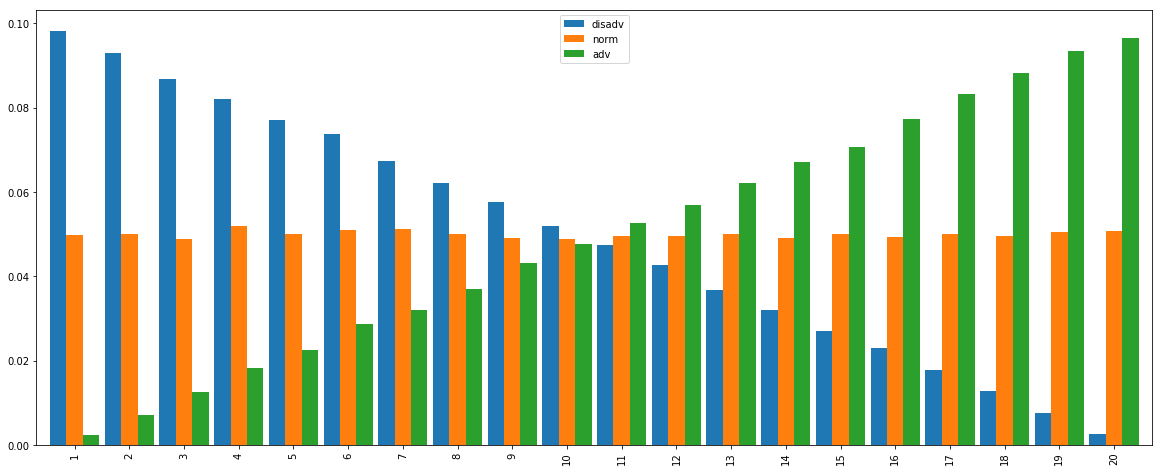

In [15]:
pd.DataFrame({"disadv": disadv, "norm": norm, "adv": adv}).plot(kind="bar", figsize=(20, 8), width=0.9)

In [10]:
(d(20).adv - d(20).disadv) * 2

<DiceExpr((adv(1d20) - disadv(1d20)) * 2)>

**todo:**
 - [ ] better batching
 - [ ] pdist (incl composability)
 - [ ] thresholding
 - [ ] roll logging
 - [ ] right-operations (e.g. `2 * d(6)`)
 - [ ] better expr collapse
 - [ ] DiceExpr.parse
 - [ ] visual output (w/ scavegr)
 - [ ] DnD numeric output (& batching)

---

In [18]:
from dicebox.dnd import attack_roll_factory, critical_roll

In [19]:
rapier_attack = attack_roll_factory("Rapier", d(8) + 4, 3)
rapier_sneak_attack = attack_roll_factory("Rapier", d(8, 6, 6, 6) + 4, 3)
rapier_assassinate_attack = attack_roll_factory("Rapier", critical_roll(d(8, 6, 6, 6) + 4), 3, critical_hits=False)

In [20]:
for i in range(20):
    print(rapier_assassinate_attack(adv=True))

Rapier: 17 to hit (adv(1d20) + 3); 39 damage (2d8 + 6d6 + 4)
Rapier: 17 to hit (adv(1d20) + 3); 36 damage (2d8 + 6d6 + 4)
Rapier: 12 to hit (adv(1d20) + 3); 25 damage (2d8 + 6d6 + 4)
Rapier: 21 to hit (adv(1d20) + 3); 37 damage (2d8 + 6d6 + 4)
Rapier: 10 to hit (adv(1d20) + 3); 32 damage (2d8 + 6d6 + 4)
Rapier: 22 to hit (adv(1d20) + 3); 36 damage (2d8 + 6d6 + 4)
Rapier: 17 to hit (adv(1d20) + 3); 37 damage (2d8 + 6d6 + 4)
Rapier: 14 to hit (adv(1d20) + 3); 29 damage (2d8 + 6d6 + 4)
Rapier: 10 to hit (adv(1d20) + 3); 39 damage (2d8 + 6d6 + 4)
Rapier: 15 to hit (adv(1d20) + 3); 37 damage (2d8 + 6d6 + 4)
Rapier: 23 to hit (adv(1d20) + 3); 27 damage (2d8 + 6d6 + 4)
Rapier: 8 to hit (adv(1d20) + 3); 36 damage (2d8 + 6d6 + 4)
Rapier: 15 to hit (adv(1d20) + 3); 31 damage (2d8 + 6d6 + 4)
Rapier: 20 to hit (adv(1d20) + 3); 38 damage (2d8 + 6d6 + 4)
Rapier: 12 to hit (adv(1d20) + 3); 34 damage (2d8 + 6d6 + 4)
Rapier: 15 to hit (adv(1d20) + 3); 31 damage (2d8 + 6d6 + 4)
Rapier: 18 to hit (adv(1d

In [21]:
turn = [rapier_sneak_attack(), rapier_attack()]
print("\n".join(turn))

Rapier: 19 to hit (1d20 + 3); 9 damage (1d8 + 3d6 + 4)
Rapier: 9 to hit (1d20 + 3); 5 damage (1d8 + 4)
